<a href="https://colab.research.google.com/github/issacridhin/Speech_Processing/blob/main/2348546_Lab4_SPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Linear Predictive Coding

LPC is a method of modelling a vocal speech tract used for predicting the current speech samples based on the previous speech samples. It is based on the idea of modelling speech samples based on the previous speech samples which is similar to regression in Machine Learning.


### Why LPC is Important:
- **Efficient Representation**: LPC reduces the amount of data needed to represent speech, which is important for compression and transmission.
- **Formant Analysis**: It can identify formants (resonant frequencies of the vocal tract), which are key to distinguishing different speech sounds.
- **Speech Synthesis**: LPC is also used in speech synthesis to recreate speech from the predictive model.


In [ ]:
# importing libraries
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from gtts import gTTS
from scipy.linalg import toeplitz


In [ ]:
# text to speech
text="A quick brown fox jumped over the lazy dog"
language='en'
audio='sample_audio.wav'

#  text to audio file using librosa library
tts=gTTS(text=text,lang=language,slow=False)
tts.save(audio)


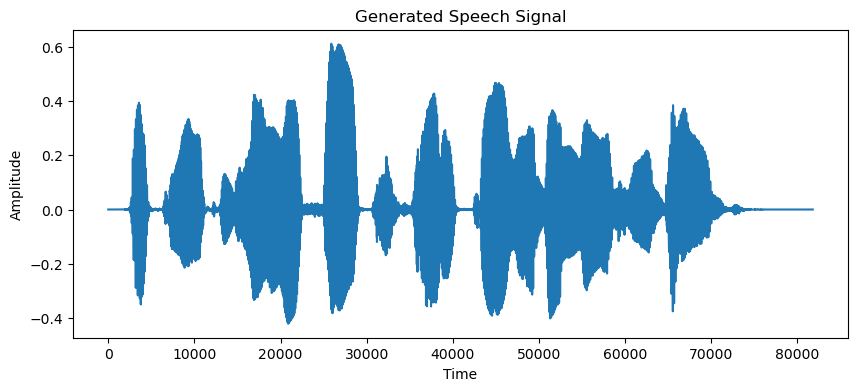

In [ ]:
# loading and plotting
signal,sr=librosa.load(audio,sr=None)

# speech signal
plt.figure(figsize=(10, 4))
plt.plot(signal)
plt.title('Generated Speech Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


# Autocorrelation method of computing LPC
Steps
- Compute the autocorrelation by windowing the speech signal by small frames to ensure stationarity of speech signal
- Set up and solve Yule-Walker equations for computing the LPC coefficients
- Compute Prediction Error
  

### Autocorrelation Function:

Autocorrelation is used here (LPC) because it helps capture the repeating patterns or periodicity in a speech signal. As the goal of LPC is to model the current speech sample as a linear combination of previous samples, which requires an understanding of how the signal behaves over time. Autocorrelation provides this insight by measuring how well the signal matches a delayed version of itself.



In [ ]:
def autocorrelation_method(signal, order):
    # calculate autocorrelation
    autocorrelation_values = np.correlate(signal, signal, mode='full')
    autocorrelation_values = autocorrelation_values[len(autocorrelation_values)//2:]  # positive lags only

    # Here lag is the number of times(or samples) by which a signal is shifted when compared to itself to assess the similarity between the delayed and the advanced versions of the signal over different time intervals to identify the the signal patterns.

    # solving the Yule-Walker equations
    R = toeplitz(autocorrelation_values[:order])   # autocorrelation values
    r = autocorrelation_values[1:order+1]  # Right-hand side of the Yule-Walker equations

    # LPC coefficients
    lpc_coeffs = np.linalg.solve(R, r)
    return np.concatenate(([1], -lpc_coeffs))  # leading 1 for filter representation


In [ ]:
# LPC order
lpc_order = 12


The order of an LPC model is the number of poles, or formants in the filter. Usually, two poles are included for each formant. Two to four poles are added to represent the source characteristics. The LPC order is related to the sample rate of the audio file:

- 10000 Hz - LPC order = 12-14 (males) and 8-10 (females);

- 22050 Hz - LPC order = 24-26 (males) and 22-24 (females).

The number of poles can be calculated as follows :

$
N_{\text{poles}} = \frac{SR}{F_{\text{max}} \times 0.25}
$

Where:
- $ N_{\text{poles}} $ is the number of poles,
- $ SR $ is the sampling rate,
- $ F_{\text{max}} $ is the maximum frequency.

LPC Coefficients: [ 1.         -1.07806563  0.33020467 -0.85682613  0.7485503  -0.59671497
  0.55301118 -0.44961509  0.62391299 -0.19096227  0.18717825 -0.2098247
 -0.02884269]


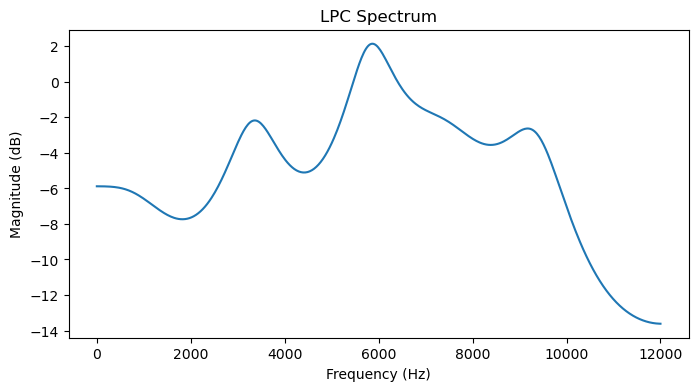

In [ ]:
from scipy.signal import freqz

# LPC coefficients
lpc_coefficients = autocorrelation_method(signal, lpc_order)
print("LPC Coefficients:", lpc_coefficients)

# frequency response of the LPC filter
w, h = freqz(1, np.hstack([[1], -lpc_coefficients[1:]]))

# Plot the magnitude of the frequency response
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, sr / 2, len(w)), 20 * np.log10(abs(h)))
plt.title("LPC Spectrum")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.show()


The LPC coefficients printed represent the filter coefficients that describe how the speech signal can be predicted from its past values.
- The first coefficient  is the normalization term.
- The remaining coefficients describe the relationship between the current sample of the speech signal and its previous samples.


The given plot above shows the LPC spectral envelope, which shows how the LPC model approximates the frequency content of the speech signal. It smooths the peaks and valleys, corresponding to the formants in the speech.

### Using the LPC Coefficients to filter the signal and predict the signal

In [ ]:
# signal reconstruction using LPC coefficients
def reconstruct_signal(signal, lpc_coeffs):
    reconstructed_signal = lfilter([0] + -lpc_coeffs[1:], [1], signal)
    return reconstructed_signal


In [ ]:
reconstructed_signal = reconstruct_signal(signal, lpc_coefficients)


In [ ]:
# prediction error (residual)
residual = signal - reconstructed_signal


# Signal Plots

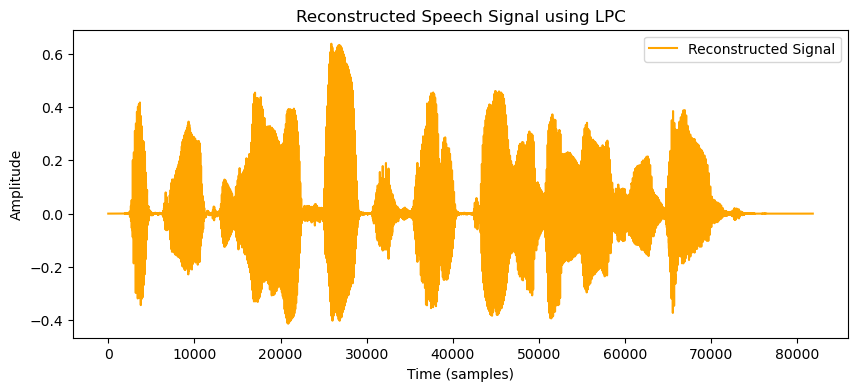

In [ ]:
# reconstructed signal
plt.figure(figsize=(10, 4))
plt.plot(reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.title('Reconstructed Speech Signal using LPC')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


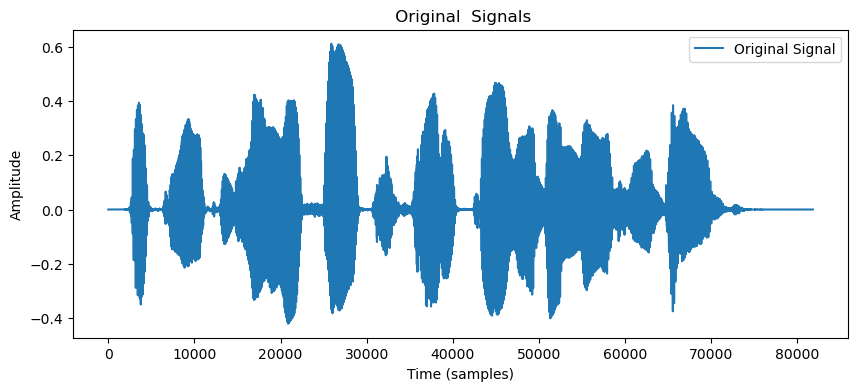

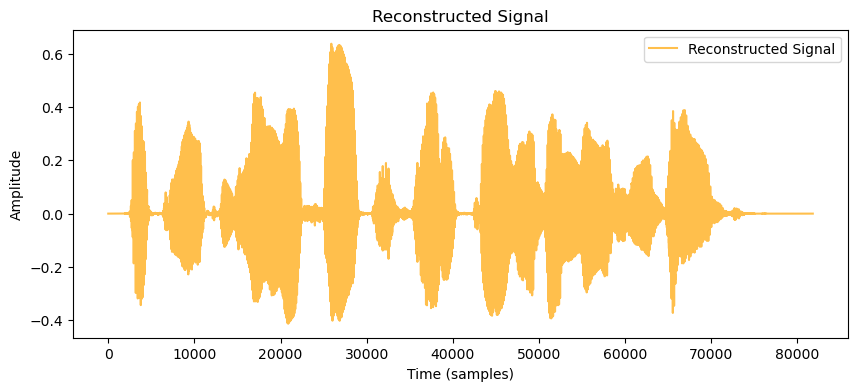

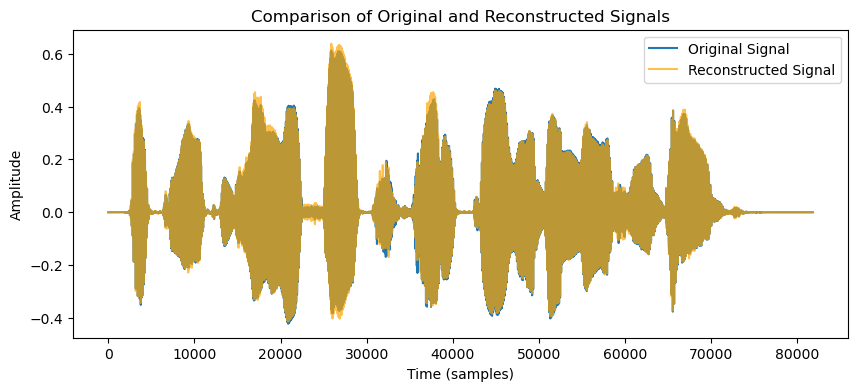

In [ ]:
# Original signal plot
plt.figure(figsize=(10, 4))
plt.plot(signal, label="Original Signal")
plt.title(' Original  Signals')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# reconstructed signal plot
plt.figure(figsize=(10, 4))
plt.plot(reconstructed_signal, label="Reconstructed Signal", color='orange', alpha=0.7)
plt.title('Reconstructed Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# comparison between original and reconstructed signals
plt.figure(figsize=(10, 4))
plt.plot(signal, label="Original Signal")
plt.plot(reconstructed_signal, label="Reconstructed Signal", color='orange', alpha=0.7)
plt.title('Comparison of Original and Reconstructed Signals')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


# Results

Observations from Plots:
- The Original Signal plot has clearly defined peaks and valleys corresponding to the speech components.
- The Reconstructed Signal plot is quite close in shape to the original signal, meaning that the LPC model has captured the major features of the speech waveform.
- In the Comparison Plot, the signals mostly overlap, but there are slight differences in some sections, showing where the LPC model deviates from the original.

The results indicate that the LPC method is effective in capturing the essential features of speech, though some fine details are lost in the reconstruction process due to the inherent approximation in modeling the vocal tract using a limited number of poles (12 in this case).